LaTeX macros (hidden cell)
$
\newcommand{\Q}{\mathcal{Q}}
\newcommand{\ECov}{\boldsymbol{\Sigma}}
\newcommand{\EMean}{\boldsymbol{\mu}}
\newcommand{\EAlpha}{\boldsymbol{\alpha}}
\newcommand{\EBeta}{\boldsymbol{\beta}}
$

# Imports and configuration

In [2]:
import sys
import os
import re
import datetime as dt

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *

from notebook.services.config import ConfigManager

from portfolio_tools import data_download, DataReader, compute_inputs

In [3]:
# Version checks
print(sys.version)
print('matplotlib: {}'.format(matplotlib.__version__))

# Jupyter configuration
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})  

# Numpy options
np.set_printoptions(precision=5, linewidth=120, suppress=True)

# Pandas options
pd.set_option('display.max_rows', None)

# Matplotlib options
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
matplotlib: 3.4.3


# Prepare input data

Here we load the raw data that will be used to compute the optimization input variables, the vector $\EMean$ of expected returns and the covariance matrix $\ECov$. The data consists of daily stock prices of $8$ stocks from the US market. 

## Download data

In [4]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data. 
# The code can be modified to download from other sources. To be able to run the examples, 
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock. 
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18, 
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
list_stocks = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
list_factors = []
alphaToken = None
 
list_tickers = list_stocks + list_factors
if alphaToken is not None:
    data_download(list_tickers, alphaToken)  

## Read data

We load the daily stock price data from the downloaded CSV files. The data is adjusted for splits and dividends. Then a selected time period is taken from the data.

In [5]:
investment_start = "2016-03-18"
investment_end = "2021-03-18"

In [6]:
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", symbol_list=list_tickers)
dr.read_data()
df_prices, _ = dr.get_period(start_date=investment_start, end_date=investment_end)

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_IWM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv

Using data files: 
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_LMT.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_CSCO.csv



# Run the optimization

## Define the optimization model

First we generate return scenario data using Monte Carlo method based on the moments of historical prices.  

In [7]:
# Number of scenarios
T = 99999

# Mean and covariance of historical log-returns.  
m_log, S_log = compute_inputs(df_prices, return_log=True)

# Generate logarithmic return scenarios assuming normal distribution
scenarios_log = np.random.default_rng().multivariate_normal(m_log, S_log, T)
    
# Convert logarithmic return scenarios to linear return scenarios 
scenarios_lin = np.exp(scenarios_log) - 1

# Scenario probabilities
p = np.ones(T) / T

We would like to optimize the 95% EVaR of the portfolio loss distribution.

In [8]:
# Confidence level
alpha = 0.95

In [9]:
# Primal CVaR formula (for testing)
def CVaR(alpha, p, q):
    # We need to be careful that math index starts from 1 but numpy starts from 0 (matters in formulas like ceil(alpha * T))
    T = q.shape[0]
    
    # Starting index 
    i_alpha = np.sort(np.nonzero(np.cumsum(p) >= alpha)[0])[0]

    # Weight of VaR component in CVaR
    lambda_alpha = (sum(p[:(i_alpha + 1)]) - alpha) / (1 - alpha)    
    
    # CVaR
    sort_idx = np.argsort(q)
    sorted_q = q[sort_idx]
    sorted_p = p[sort_idx]
    cvar = lambda_alpha * sorted_q[i_alpha] + np.dot(sorted_p[(i_alpha + 1):], sorted_q[(i_alpha + 1):]) / (1 - alpha)
    
    return cvar

Below we implement the optimization model in Fusion API. We create it inside a function so we can call it later.

In [10]:
# s * log(sum_i(p_i * exp(x_i / s))) <= t
def persplogsumexp(M, x, s, p, t):
    n = int(x.getSize())
    u = M.variable(n)
    M.constraint(Expr.hstack(u, Var.repeat(s, n), Expr.sub(x, Var.repeat(t, n))), Domain.inPExpCone())
    M.constraint(Expr.sub(Expr.dot(p, u), s), Domain.lessThan(0.0))
    

def EfficientFrontier(N, T, m, R, p, alpha, deltas):

    with Model("Case study") as M:
        # Settings
        #M.setLogHandler(sys.stdout)
        
        # Variables 
        # The variable x is the fraction of holdings relative to the initial capital.
        # It is constrained to take only positive values. 
        x = M.variable("x", N, Domain.greaterThan(0.0))
        
        # Budget constraint
        M.constraint('budget', Expr.sum(x), Domain.equalsTo(1.0))
        
        # Auxiliary variables.
        z = M.variable("z", 1, Domain.unbounded())
        t = M.variable("t", 1, Domain.greaterThan(0.0))
        
        # Constraint modeling perspective of log-sum-exp
        persplogsumexp(M, Expr.mul(-R, x), t, p, z)
        
        # Objective
        delta = M.parameter()
        evar_term = Expr.sub(z, Expr.mul(t, np.log(1.0 - alpha)))
        M.objective('obj', ObjectiveSense.Maximize, Expr.sub(Expr.dot(m, x), Expr.mul(delta, evar_term)))
        
        # Create DataFrame to store the results.
        columns = ["delta", "obj", "return", "risk", "evar"] + df_prices.columns.tolist()
        df_result = pd.DataFrame(columns=columns)
        for d in deltas:
            # Update parameter
            delta.setValue(d);
        
            # Solve optimization
            M.solve()

            # Save results
            portfolio_return = m @ x.level()
            portfolio_risk = z.level()[0] - t.level()[0] * np.log(1.0 - alpha)
            cvar = CVaR(alpha, p, -R @ x.level())
            row = pd.Series([d, M.primalObjValue(), portfolio_return, portfolio_risk, cvar] + list(x.level()), index=columns)
            df_result = pd.concat([df_result, pd.DataFrame([row])], ignore_index=True)
            
            # Check CVaR value using primal formula
            print(f"Relative difference between EVaR and CVaR (%): {(cvar - portfolio_risk) / portfolio_risk * 100}")

        return df_result

## Compute optimization input variables

Here we use the loaded daily price data to compute the corresponding yearly mean return and covariance matrix.

In [11]:
# Number of securities
N = df_prices.shape[1]  

# Get optimization parameters
m, _ = compute_inputs(df_prices)

## Call the optimizer function

We run the optimization for a range of risk aversion parameter values: $\delta = 10^{-1},\dots,10^{2}$. We compute the efficient frontier this way both with and without using shrinkage estimation. 

In [12]:
# Compute efficient frontier with and without shrinkage
deltas = np.logspace(start=-1, stop=2, num=20)[::-1]
df_result = EfficientFrontier(N, T, m, scenarios_lin, p, alpha, deltas)

Relative difference between EVaR and CVaR (%): -34.53852375140152
Relative difference between EVaR and CVaR (%): -34.56133871993644
Relative difference between EVaR and CVaR (%): -34.59273754037627
Relative difference between EVaR and CVaR (%): -34.637057865626836
Relative difference between EVaR and CVaR (%): -34.698888808433864
Relative difference between EVaR and CVaR (%): -34.77959553645075
Relative difference between EVaR and CVaR (%): -34.86377484300579
Relative difference between EVaR and CVaR (%): -34.95529772021655
Relative difference between EVaR and CVaR (%): -35.064713926103245
Relative difference between EVaR and CVaR (%): -35.1241315284922
Relative difference between EVaR and CVaR (%): -34.9647056153214
Relative difference between EVaR and CVaR (%): -34.66137851663209
Relative difference between EVaR and CVaR (%): -34.09825944130193
Relative difference between EVaR and CVaR (%): -33.00483816326271
Relative difference between EVaR and CVaR (%): -32.79577245919599
Relative 

Check the results.

In [13]:
df_result

,delta,obj,return,risk,evar,PM,LMT,MCD,MMM,AAPL,MSFT,TXN,CSCO
0,100.000000,-14.938545,0.350789,0.152893,0.100086,-1.264561e-10,1.683676e-02,1.236279e-01,-3.885737e-11,0.089694,0.566750,2.030909e-01,7.076014e-10
1,69.519280,-10.278148,0.351474,0.152902,0.100057,-5.864386e-10,1.554612e-02,1.219758e-01,2.510658e-09,0.090397,0.568896,2.031845e-01,4.480181e-08
2,48.329302,-7.038009,0.352460,0.152919,0.100020,-1.530737e-10,1.368995e-02,1.195955e-01,-1.132469e-10,0.091414,0.571986,2.033153e-01,9.097379e-11
3,33.598183,-4.785129,0.353883,0.152955,0.099976,-3.472677e-10,1.101887e-02,1.161613e-01,6.561799e-09,0.092885,0.576439,2.034958e-01,7.559668e-08
4,23.357215,-3.218408,0.355935,0.153030,0.099930,-7.126505e-12,7.174634e-03,1.112020e-01,3.481739e-09,0.095020,0.582863,2.037404e-01,1.471188e-08
5,16.237767,-2.128474,0.358903,0.153185,0.099908,-4.425449e-10,1.639975e-03,1.040198e-01,-2.579538e-10,0.098137,0.592144,2.040599e-01,3.760005e-09
6,11.288379,-1.369740,0.362449,0.153449,0.099951,-1.685106e-10,2.290518e-07,9.061737e-02,6.833402e-10,0.102686,0.603703,2.029936e-01,5.074501e-09
7,7.847600,-0.841022,0.367306,0.153974,0.100152,-4.432324e-10,2.830167e-07,7.012494e-02,-6.768647e-11,0.109383,0.619713,2.007794e-01,5.317776e-09
8,5.455595,-0.471650,0.374360,0.155072,0.100697,-3.010627e-10,5.072163e-08,4.048192e-02,6.111036e-10,0.119324,0.642879,1.973151e-01,1.167637e-08
9,3.792690,-0.212212,0.384149,0.157240,0.102011,4.353928e-10,1.534210e-08,5.219122e-06,1.946002e-09,0.134107,0.674892,1.909956e-01,4.107372e-08


## Visualize the results

Plot the efficient frontier.

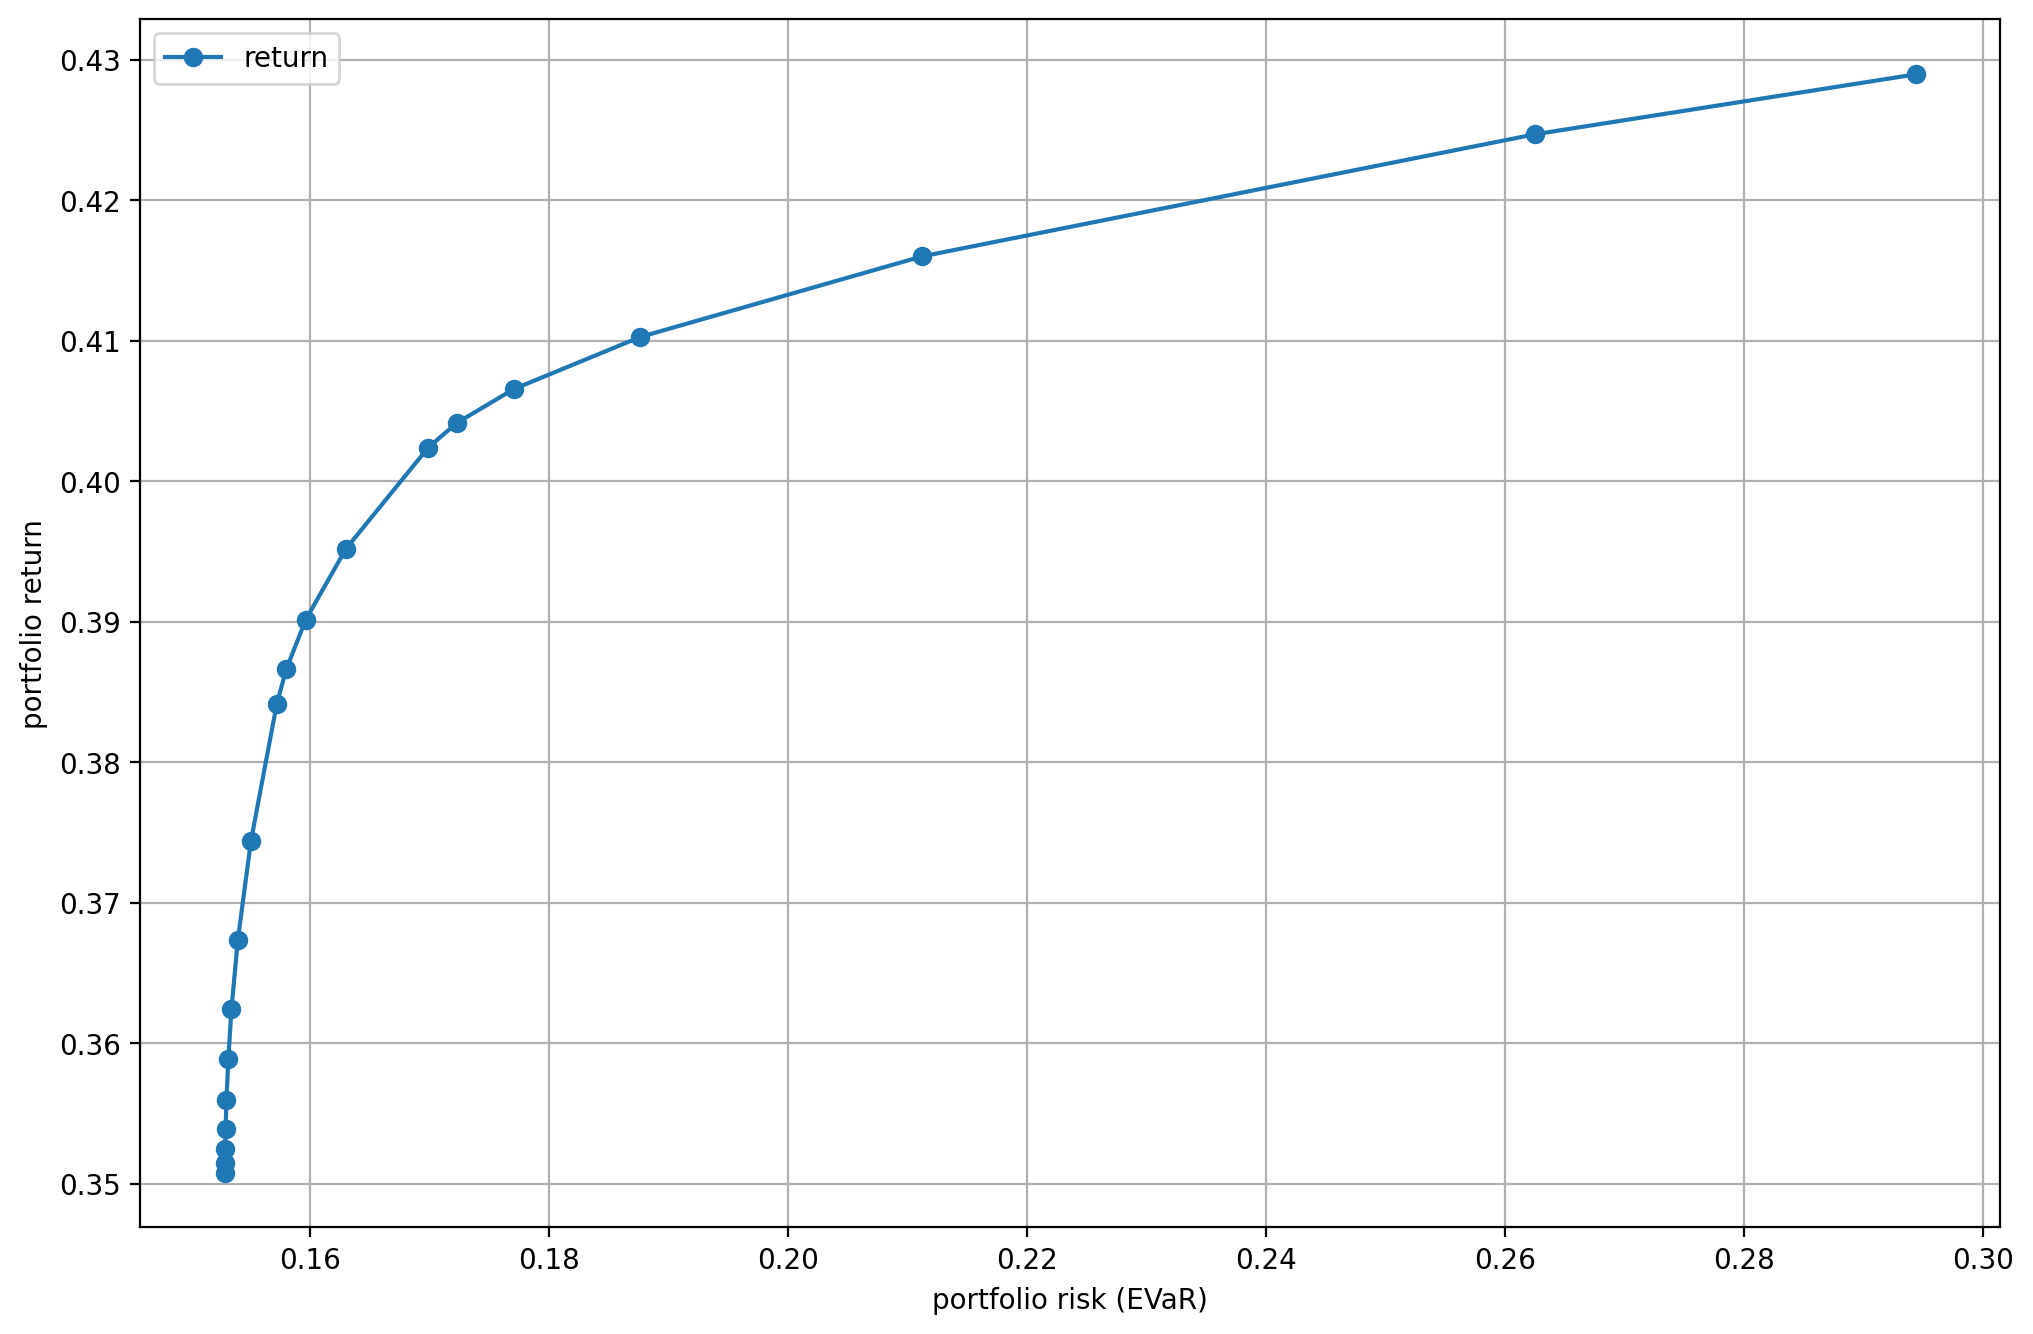

In [14]:
ax = df_result.plot(x="risk", y="return", style="-o", 
                    xlabel="portfolio risk (EVaR)", ylabel="portfolio return", grid=True)   
ax.legend(["return"]);

Plot the portfolio composition.

In [15]:
# Round small values to 0 to make plotting work
mask = np.absolute(df_result) < 1e-7
mask.iloc[:, :-8] = False
df_result[mask] = 0

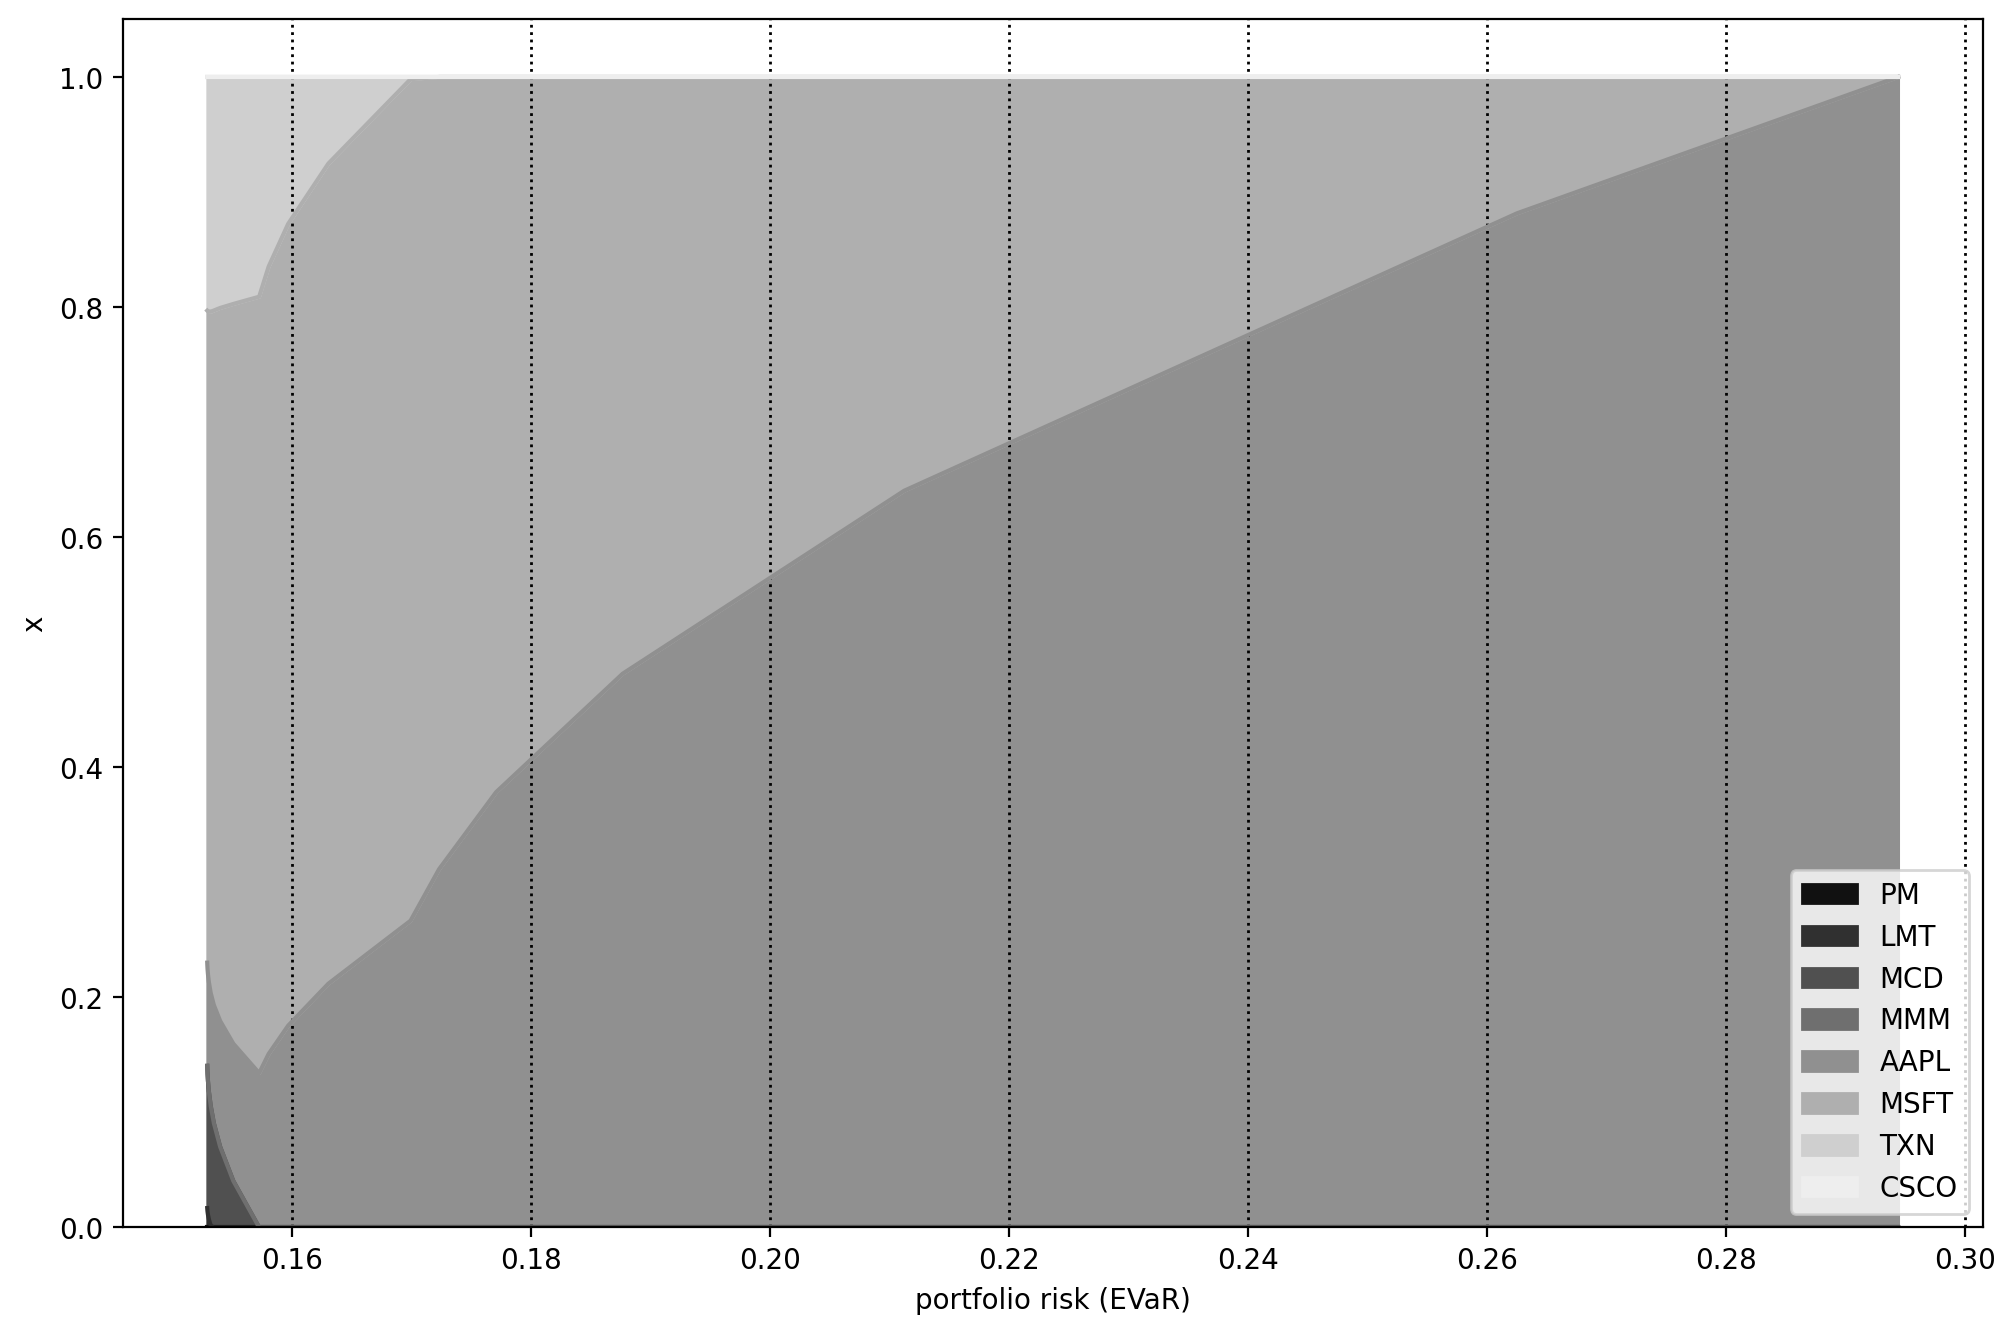

In [16]:
my_cmap = LinearSegmentedColormap.from_list("non-extreme gray", ["#111111", "#eeeeee"], N=256, gamma=1.0)
ax = df_result.set_index('risk').iloc[:, 4:].plot.area(colormap=my_cmap, xlabel='portfolio risk (EVaR)', ylabel="x") 
ax.grid(which='both', axis='x', linestyle=':', color='k', linewidth=1)